In [1]:
from diffusers import AutoPipelineForText2Image
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import torch
from PIL import Image, ImageDraw, ImageFont
import arabic_reshaper
from bidi.algorithm import get_display
import cv2
import numpy as np
import nltk
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def count_tokens(english_text):
    tokens = nltk.word_tokenize(english_text)
    return len(tokens)

In [3]:
def text_summarizer(text):
    summarizer = pipeline("summarization", model="Falconsai/text_summarization")
    return summarizer(text, max_length=77, min_length=30, do_sample=False)[0]["summary_text"]

In [4]:

ARABIC_TO_ENGLISH = {
    'ا': 'a',
    'أ': 'a',
    'إ': 'a',
    'آ': 'a',

    'ب': 'b',
    'ت': 't',
    'ث': 'th',
    'ج': 'j',

    'ح': 'h',
    'خ': 'kh',
    'د': 'd',
    'ذ': 'th',

    'ر': 'r',
    'ز': 'z',
    'س': 's',
    'ش': 'sh',

    'ص': 's',
    'ض': 'd',
    'ط': 't',
    'ظ': 'z',

    'ع': 'aa',
    'غ': 'gh',
    'ف': 'f',
    'ق': 'q',

    'ك': 'k',
    'ل': 'l',
    'م': 'm',
    'ن': 'n',

    'ه': 'h',
    'ة': 'h',
    'و': 'w',
    'ي': 'y'
}

def replace_arabic_with_english_letters(text):
    for arabic, english in ARABIC_TO_ENGLISH.items():
        text = text.replace(arabic, english)
    return text

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ar-en")
tokenizer.save_pretrained("./Arabic2English-Tokenizer")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-ar-en")
model.save_pretrained("./Arabic2English-Model")

C:\ProgramData\anaconda3\Lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
pipe = AutoPipelineForText2Image.from_pretrained("C:\\Users\\Youssef Tarek\\LiteraryHub\\src\\books-cover-generator\\Sdxlturbo", torch_dtype=torch.float32, variant="fp16")
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.1",
  "_name_or_path": "C:\\Users\\Youssef Tarek\\LiteraryHub\\src\\books-cover-generator\\Sdxlturbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
def arabic2english(text):
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids, num_beams=5, num_return_sequences=3)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [8]:
def gen_img(prompt, num_inference_steps=5, guidance_scale=1.0):
    return pipe(prompt=prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]

In [9]:
def resize_gen_img(img):
    # Convert PIL image to NumPy array
    numpy_image = np.array(img)
    
    # Convert RGB to BGR (OpenCV uses BGR color format)
    img = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    # Resize the image to the desired dimensions
    resized_img = cv2.resize(img, (6*96, 9*96))

    # Convert OpenCV image (BGR format) to RGB
    resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

    # Convert numpy array to PIL Image
    pil_image = Image.fromarray(resized_img_rgb)

    return pil_image

In [10]:
def blur_rectangle(image, x_percentage, y_percentage, width_percentage, height_percentage):
    # Convert PIL image to NumPy array
    numpy_image = np.array(image)
    
    # Convert RGB to BGR (OpenCV uses BGR color format)
    image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    
    # Get image dimensions
    height, width, _ = image.shape
    
    # Calculate rectangle dimensions based on percentages
    x = int(width * x_percentage)
    y = int(height * y_percentage)
    w = int(width * width_percentage)
    h = int(height * height_percentage)
    
    # Calculate rectangle coordinates
    x1 = x - w // 2
    y1 = y - h // 2
    x2 = x + w // 2
    y2 = y + h // 2
    
    # Create a copy of the image
    blurred_image = image.copy()
    
    # Blur the specified rectangle
    blurred_image[y1:y2, x1:x2] = cv2.GaussianBlur(blurred_image[y1:y2, x1:x2], (25, 25), 0)

    # Convert OpenCV image (BGR format) to RGB
    blurred_img_rgb = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB)

    # Convert numpy array to PIL Image
    pil_image = Image.fromarray(blurred_img_rgb)
    return pil_image

In [11]:
def add_en_text(english_title, arabic_title, arabic_authors, english_authors, image, x_percentage, y_percentage, width_percentage, height_percentage):
    image_temp = image
    # Convert PIL image to NumPy array
    numpy_image = np.array(image_temp)
    
    # Convert RGB to BGR (OpenCV uses BGR color format)
    image_temp = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)
    
    # Get image dimensions
    height, width, _ = image_temp.shape
    
    # Calculate rectangle dimensions based on percentages
    x = int(width * x_percentage)
    y = int(height * y_percentage)
    w = int(width * width_percentage)
    h = int(height * height_percentage)
    
    title_font_resize = cv2.FONT_HERSHEY_SIMPLEX
    arabic_title_font = ImageFont.truetype('AA Sameer Qamri Regular.ttf',size=55)
    arabic_title = arabic_reshaper.reshape(arabic_title)

    # Add text to the center of the blurred rectangle
    title_text_size = cv2.getTextSize(english_title, title_font_resize, 1, 2)[0]
    title_text_x = x - title_text_size[0] // 2 
    title_text_y = (y + title_text_size[1] // 2 ) - 150

    image = ImageDraw.Draw(image)
    image.text((title_text_x, title_text_y), get_display(arabic_title),font=arabic_title_font,fill='black')

 
    authors_font = cv2.FONT_ITALIC

    counter = 50
    authors_arabic_title_font = ImageFont.truetype('AA Sameer Qamri Regular.ttf',size=30)
    for i in range(len(english_authors)):
        authors_text_size = cv2.getTextSize(english_authors[i], authors_font, 1, 2)[0]
        authors_text_x = x - authors_text_size[0] // 2 + 30
        authors_text_y = (y + authors_text_size[1] // 2 ) - counter
        image.text((authors_text_x, authors_text_y), get_display(arabic_reshaper.reshape(arabic_authors[i])),font=authors_arabic_title_font,fill='black')
        counter = counter - 30
    
    # result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # # # Convert numpy array to PIL Image
    # # pil_image = Image.fromarray(result_img)
    # # return pil_image
    return image

In [12]:
def generate_book_cover(arabic_title, arabic_authors, book_summary, num_inference_steps, guidance_scale):
    english_book_summary = arabic2english(book_summary) 

    if count_tokens(english_book_summary) > 77:
        english_book_summary = text_summarizer(english_book_summary)
        
    english_title = arabic2english(arabic_title)
    gen_image = gen_img(prompt=english_book_summary, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
    resized_img = resize_gen_img(gen_image)
    base_cover = blur_rectangle(image=resized_img, x_percentage=0.5, y_percentage=0.8, width_percentage=0.9, height_percentage=0.3)

    english_authors = []
    for i in range(len(arabic_authors)):
        english_authors.append(replace_arabic_with_english_letters(arabic_authors[i]))

    result_cover = add_en_text(english_title, arabic_title, arabic_authors, english_authors, base_cover, x_percentage=0.5, y_percentage=0.8, width_percentage=0.9, height_percentage=0.3)

    return result_cover

In [13]:
book_title = "الطريق"
book_summary = """تدور أحداث هذه الرواية التي قدمها الأديب المصري نجيب محفوظ في عام 1964 في كل من العاصمة المصرية القاهرة ومدينة الإسكندرية، حيث تتحدث عن أحد الأشخاص الذين قد جبلت حياتهم بالمشاكل والآلام والذي يدعى “صابر” حيث أنّه يكون قد ولد لأم تعمل في مجال الأعمال الغير أخلاقية، وعندما يكبر يستفسر من والدته عن والده “سيد رحيمي” ومن هو، فتخبره بأن والده قد توفي وهو ما زال طفلا صغيرا، وهنا يقتنع بكلامها ويعيش معها مدة طويلة من الزمن معتقداً بان والده قد مات، هذه المدة التي لم يكن قد تعلم بها أي شيء ولم يتقن أي مهنة كانت، وفي احدى المرات يتم القبض على والدته بتهمة العمل الغير أخلاقي الذي تمتهنه، ويتم مصادرة كل أموالها لدرجة أنه لم يبقى منه شيئاً يستطيع أن يصرف على نفسه منه، وبعدها يتم إدخال والدته إلى السجن."""
book_cover = generate_book_cover(arabic_title=book_title, arabic_authors=["المؤلف", "نجيب محفوظ"], book_summary=book_summary, num_inference_steps=5, guidance_scale=0.6)

  0%|          | 0/5 [00:00<?, ?it/s]

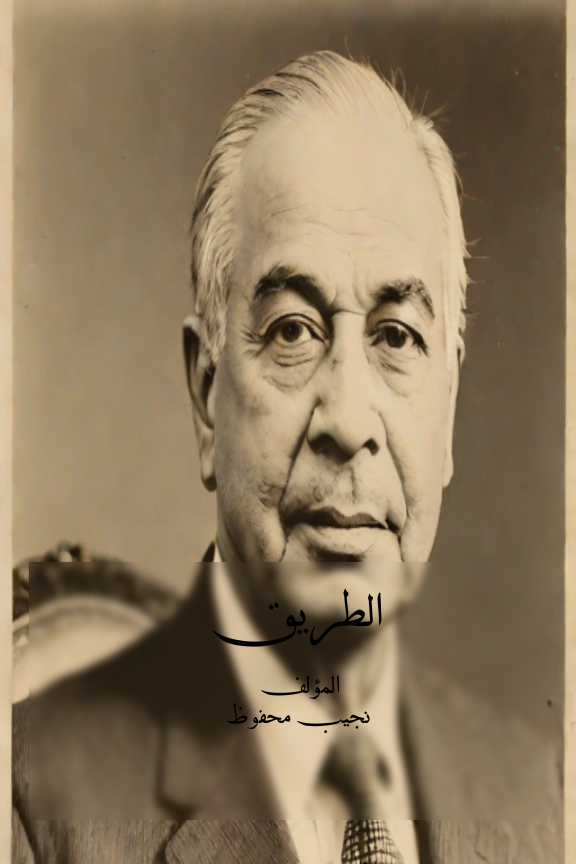

In [14]:
book_cover._image